In [76]:
import os
import pandas as pd
import pickle
from importlib import reload
import lime.lime_rdf

moviePath = "/workspaces/rdflime/rdflime-util/data/metacritic-movies"
movieFull = pd.read_csv(os.path.join(moviePath, "movies_fixed.tsv"), sep="\t")
movies = [movie.DBpedia_URI for _, movie in movieFull.iterrows()]

In [77]:
movie_search = lambda query: [(i,x) for i,x in enumerate(movies) if query.lower() in x.lower()]
movie_search("star_wars")

[(7, 'http://dbpedia.org/resource/Star_Wars_(film)'),
 (1450, 'http://dbpedia.org/resource/Star_Wars:_The_Clone_Wars_(film)')]

In [78]:
reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

with open(os.path.join(moviePath, "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

with open(os.path.join(moviePath, "embedding_classifier_cbow_200"), "rb") as file:
    clf = pickle.load(file)

explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=movies,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)

explained_entity_id = 106
explained_entity_uri = movies[explained_entity_id]
prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])
print("Explaining", explained_entity_uri)
print("Original prediction:", prediction)

data, labels, distances, explanation = explainer.explain_instance(
    entity=explained_entity_uri, 
    classifier_fn=clf.predict_proba,
    num_features=10,
    num_samples=2500,
    max_removed_triples=5,
    removal_count_fixed=False,
    use_w2v_freeze=False,
    center_correction=True,
    distance_metric="cosine",
    model_regressor=None
)

Explaining http://dbpedia.org/resource/Star_Trek_II:_The_Wrath_of_Khan
Original prediction: [[0.02075634 0.97924366]]


100%|██████████| 2500/2500 [00:08<00:00, 304.11it/s]


Average remaining walks per artificial entity (from 484): 466.9056


237

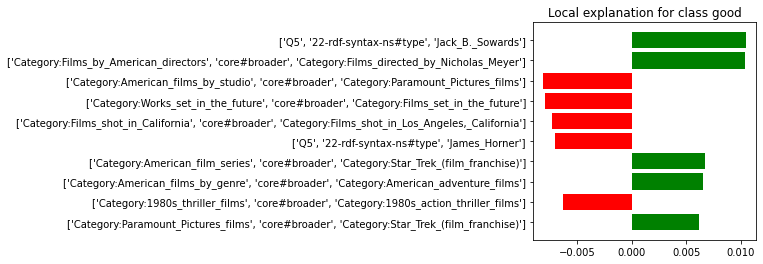

In [70]:
# make many copies of embedder 
figsize = (4, .4*len(explanation.as_list()))
fig = explanation.as_pyplot_figure(figsize=figsize)

In [39]:
explanation.domain_mapper.triples[1]

('http://dbpedia.org/resource/Category:Films_shot_in_Sydney',
 'http://purl.org/dc/terms/subject',
 'http://dbpedia.org/resource/The_Matrix')

In [54]:
explanation.as_list()

[(('http://dbpedia.org/resource/Star_Wars_(film)',
   'http://purl.org/dc/terms/subject',
   'http://dbpedia.org/resource/Category:American_films'),
  -0.0002158736681652554),
 (('http://schema.org/Movie',
   'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
   'http://dbpedia.org/resource/Star_Wars_(film)'),
  -0.00020232405345759573),
 (('http://dbpedia.org/resource/Star_Wars_(film)',
   'http://purl.org/dc/terms/subject',
   'http://dbpedia.org/resource/Category:Films_whose_editor_won_the_Best_Film_Editing_Academy_Award'),
  -0.00019146706017753154),
 (('http://dbpedia.org/resource/Star_Wars_(film)',
   'http://purl.org/dc/terms/subject',
   'http://dbpedia.org/resource/Category:Cyborg_films'),
  -0.00018489488559324835),
 (('http://dbpedia.org/resource/Star_Wars_(film)',
   'http://purl.org/dc/terms/subject',
   'http://dbpedia.org/resource/Category:Lucasfilm_films'),
  -0.00016848672245015707),
 (('http://dbpedia.org/resource/Star_Wars_(film)',
   'http://dbpedia.org/ontology/dir

In [99]:
print(min(labels[:, 1]), max(labels[:, 1]))

0.0010876746292062568 0.019374033255014234


In [51]:
labels

array([[0.02073906, 0.97926094],
       [0.02035596, 0.97964404],
       [0.0204522 , 0.9795478 ],
       [0.02073064, 0.97926936],
       [0.02053432, 0.97946568],
       [0.02060695, 0.97939305],
       [0.02024076, 0.97975924],
       [0.02009378, 0.97990622],
       [0.02034037, 0.97965963],
       [0.02063684, 0.97936316]])

In [31]:
wv_old = explainer.oldTransformer.embedder._model.wv
wv_new = explainer.transformer.embedder._model.wv
def embedding(URI, new):
    wv = wv_new if new else wv_old
    return wv.get_vector(URI)

In [26]:
cinderella_man = "http://dbpedia.org/resource/Cinderella_Man"

embedding(cinderella_man, new=True) == embedding(cinderella_man, new=False)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [32]:
dif_to_center = embedding(cinderella_man+"*0*", new=True) - embedding(cinderella_man, new=True)
a = embedding(cinderella_man+"*1*", new=True) - dif_to_center
wv_new.most_similar(a)

[('http://dbpedia.org/resource/Cinderella_Man', 0.9999447464942932),
 ('http://dbpedia.org/resource/Backdraft_(film)', 0.6019250750541687),
 ('http://dbpedia.org/resource/Abandon_(film)', 0.596493661403656),
 ('http://dbpedia.org/resource/Blue_Crush', 0.5888547897338867),
 ('http://dbpedia.org/resource/The_Player_(film)', 0.5883273482322693),
 ('http://dbpedia.org/resource/Dazed_and_Confused_(film)', 0.5844845175743103),
 ('http://dbpedia.org/resource/Category:Screenplays_by_Akiva_Goldsman',
  0.5787481069564819),
 ('http://dbpedia.org/resource/The_Skulls_(film)', 0.576318085193634),
 ('http://dbpedia.org/resource/Simon_Birch', 0.5673640966415405),
 ('http://dbpedia.org/resource/October_Sky', 0.5612045526504517)]

In [33]:
wv_new.most_similar(embedding(cinderella_man, new=True))

[('http://dbpedia.org/resource/Cinderella_Man', 1.0000001192092896),
 ('http://dbpedia.org/resource/Backdraft_(film)', 0.6000975966453552),
 ('http://dbpedia.org/resource/Abandon_(film)', 0.5968028903007507),
 ('http://dbpedia.org/resource/Blue_Crush', 0.5883461833000183),
 ('http://dbpedia.org/resource/The_Player_(film)', 0.5879160165786743),
 ('http://dbpedia.org/resource/Dazed_and_Confused_(film)', 0.5848406553268433),
 ('http://dbpedia.org/resource/Category:Screenplays_by_Akiva_Goldsman',
  0.5781734585762024),
 ('http://dbpedia.org/resource/The_Skulls_(film)', 0.576590895652771),
 ('http://dbpedia.org/resource/Simon_Birch', 0.5680033564567566),
 ('http://dbpedia.org/resource/Jerry_Maguire', 0.5619823932647705)]

In [5]:
explainer.oldTransformer.embedder._model.wv.most_similar(x[123])

[('http://dbpedia.org/resource/Cinderella_Man', 1.0000001192092896),
 ('http://dbpedia.org/resource/Backdraft_(film)', 0.6000975966453552),
 ('http://dbpedia.org/resource/Abandon_(film)', 0.5968028903007507),
 ('http://dbpedia.org/resource/Blue_Crush', 0.5883461833000183),
 ('http://dbpedia.org/resource/The_Player_(film)', 0.5879160165786743),
 ('http://dbpedia.org/resource/Dazed_and_Confused_(film)', 0.5848406553268433),
 ('http://dbpedia.org/resource/Category:Screenplays_by_Akiva_Goldsman',
  0.5781734585762024),
 ('http://dbpedia.org/resource/The_Skulls_(film)', 0.576590895652771),
 ('http://dbpedia.org/resource/Simon_Birch', 0.5680033564567566),
 ('http://dbpedia.org/resource/Jerry_Maguire', 0.5619823932647705)]

In [64]:
wvNew = explainer.transformer.embedder._model.wv

wvNew.most_similar(cinderella_man+"*19*")


wvNew.get_vector(cinderella_man+"*5*")








array([ 0.01920439, -0.01917059, -0.01651181, -0.01652301, -0.01858101,
       -0.01670909,  0.00652348, -0.01793889,  0.0139054 ,  0.00485731,
        0.01814482, -0.01211903, -0.00447576,  0.01589042,  0.01041324,
        0.01866846, -0.00270528, -0.00374249,  0.01114732, -0.0021802 ,
        0.01061333, -0.0161376 ,  0.00088714,  0.00148041,  0.01673099,
        0.00537844,  0.00518128, -0.01879095,  0.01506278,  0.01363979,
       -0.01956757, -0.00913975, -0.01164664, -0.01946638, -0.00928497,
       -0.00506615,  0.01974719, -0.00252509,  0.01917149,  0.0165253 ,
       -0.00078658,  0.00164425, -0.01374285, -0.00030615, -0.00985807,
       -0.0186675 , -0.00576478,  0.01429979, -0.00348817, -0.01843766],
      dtype=float32)

In [43]:
wvNew.most_similar(x[9999])

IndexError: list index out of range

In [64]:
data[4]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
print(walks)

In [24]:
for walk in explainer.indexedWalks.walks(e):
    for step in walk:
        if not step in changed and not step == e:
            print(step)

In [21]:
bad = 0
changed = []

for i in range(len(wv_old)):
    if not (wv_old[i] == wv_new[i]).all():
        print(wv_new.index_to_key[i])
        changed.append(wv_new.index_to_key[i])

        bad += 1

print(bad) 

http://purl.org/dc/terms/subject
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://www.w3.org/2004/02/skos/core#broader
http://dbpedia.org/ontology/starring
http://www.w3.org/2004/02/skos/core#Concept
http://www.w3.org/2004/02/skos/core#prefLabel
http://dbpedia.org/ontology/producer
http://www.w3.org/2002/07/owl#Thing
http://dbpedia.org/ontology/writer
http://dbpedia.org/ontology/director
http://dbpedia.org/ontology/distributor
http://dbpedia.org/resource/Category:American_films
http://dbpedia.org/ontology/musicComposer
http://dbpedia.org/ontology/Work
http://dbpedia.org/ontology/Wikidata:Q11424
http://schema.org/Movie
http://www.wikidata.org/entity/Q386724
http://dbpedia.org/ontology/Film
http://schema.org/CreativeWork
http://dbpedia.org/resource/Category:English-language_films
http://dbpedia.org/ontology/cinematography
http://dbpedia.org/ontology/occupation
http://dbpedia.org/ontology/birthPlace
http://dbpedia.org/ontology/editing
http://dbpedia.org/ontology/Agent
http://dbpedia

In [56]:
keanu = embedding("http://dbpedia.org/resource/Keanu_Reeves", new=True)
matrix = embedding("http://dbpedia.org/resource/The_Matrix", new=True)
wv_new.most_similar(matrix-keanu, topn=len(wv_new))[-2]

('http://dbpedia.org/resource/Judy_Greer', -0.5391753911972046)

In [57]:
wv_new.most_similar(positive=["http://dbpedia.org/resource/The_Matrix"], negative=["http://dbpedia.org/resource/Keanu_Reeves"])

[('http://dbpedia.org/resource/The_Matrix_Reloaded', 0.6328825354576111),
 ('http://dbpedia.org/resource/The_Empire_Strikes_Back', 0.6072103977203369),
 ('http://dbpedia.org/resource/District_9', 0.5993965268135071),
 ('http://dbpedia.org/resource/Rambo_III', 0.5748681426048279),
 ('http://dbpedia.org/resource/Category:Gun_fu_films', 0.5665922164916992),
 ('http://dbpedia.org/resource/Fast_Five', 0.5504526495933533),
 ('http://dbpedia.org/resource/Blade_Runner', 0.5391538143157959),
 ('http://dbpedia.org/resource/Alien:_Resurrection', 0.5331454873085022),
 ('http://dbpedia.org/resource/G.I._Jane', 0.5284064412117004),
 ('http://dbpedia.org/resource/The_Condemned', 0.5274669528007507)]

In [59]:
wv_new.most_similar("http://dbpedia.org/resource/Blade_Runner")

[('http://dbpedia.org/resource/The_Matrix', 0.7232573628425598),
 ('http://dbpedia.org/resource/RoboCop', 0.681049644947052),
 ('http://dbpedia.org/resource/The_Terminator', 0.6796393394470215),
 ('http://dbpedia.org/resource/The_Condemned', 0.6456360816955566),
 ('http://dbpedia.org/resource/Category:Drone_films', 0.6386860609054565),
 ('http://dbpedia.org/resource/The_Matrix_Reloaded', 0.6282235980033875),
 ('http://dbpedia.org/resource/RoboCop__1', 0.625795841217041),
 ('http://dbpedia.org/resource/The_Matrix_(franchise)', 0.6230692267417908),
 ('http://dbpedia.org/resource/Jerry_Goldsmith__1', 0.6173606514930725),
 ('http://dbpedia.org/resource/Garry_Kasparov__2', 0.6136869788169861)]

### Experiments

In [ ]:
unique_triples = len(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri)))
unique_triples